# Instructions

As in the previous assignment, youl'll be using PyTorch instead of EDF. This assignment will focus on generative modelling, and you'll implement and train a VAE and a GAN.

It is highly suggested to use google colab and run the notebook on a GPU node.
Check https://colab.research.google.com/ and look for tutorials online on how to use it. To use a GPU go to Runtime -> Change runtime type and select GPU.

In [2]:
import torch, math, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from scipy.stats import kde
import matplotlib.pyplot as plt

We'll start by coding up a toy problem and seeing how a VAE and a GAN behave on it. Consider the following stochastic process:
$$ \mu_x \sim U(\{1,2,3\})$$
$$ \mu_y \sim U(\{1,2,3\})$$
$$ s \sim \mathcal N \left([\mu_x, \mu_y], \frac{1}{100}I \right)$$
where $I$ is the $2 \times 2$ identity matrix.

Implement the function in the next cell such that it returns $n$ samples distributed as $s$ from the above process. The returned object should be a $n \times 2$ PyTorch tensor.

In [2]:
def sample(n):
    
    mean = torch.randint(1, 4, (n,2), dtype=torch.float32)
    std = torch.ones(n,2)/100
    s = torch.normal(mean,std)
    
    return s


Now we'll sample 1000 points and see how they are distributed.

In [3]:
def plot_density(data):
    data = data.numpy()
    nbins = 50
    x, y = data.T
    k = kde.gaussian_kde(data.T)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)

    plt.tight_layout()
    plt.show()
    plt.clf()

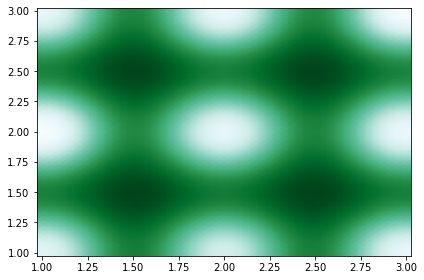

<Figure size 432x288 with 0 Axes>

In [4]:
data = sample(1000)
plot_density(data)

## VAE on a Toy Problem

Recall that when training a VAE we're concerned with the following problem:

$$\min_{\phi} \,\ \mathbb E_{x \sim Pop, z \sim P_\phi(z|x)} \left[ \ln \frac{P_\phi(z|x)}{P(z)} - \ln P_\phi(x|z) \right] \,.$$

We'll model $P_\phi(z|x)$ with an encoder and $P_\phi(x|z)$ with a decoder as follows:
$$P_\phi(z|x) = \mathcal N \left(\mu_{\phi,z}(x), \Sigma_{\phi,z}(x) \right)$$
$$P_\phi(x|z) = \mathcal N \left( \mu_{\phi,x}(z), \sigma^2 I \right) \,,$$
where $\mu_{\phi,z}, \Sigma_{\phi,z}, \mu_{\phi,x}$ are neural networks, and $\Sigma_{\phi,z}(x)$ is diagonal.

Moreover, let $P(z)$ (the prior over $z$) to be $\mathcal N(0, I)$.


**<span style="color:blue">
    For the above distributions, what is $\ln P_\phi(x|z)$ as a function of $x, z, \mu_{\phi,x}$, and $\sigma$?
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

In general, a multivariate normal distribution over $n$ variables is defined as 

$$
P(y) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}\exp-\frac{1}{2}(y-\mu)^{T}\Sigma^{-1}(y-\mu)
$$

In this case we have

\begin{eqnarray}
\ln P_\phi(x|z) &=& \ln \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}\exp-\frac{1}{2\sigma^{2}}(x-\mu_{\phi,x}(z))^{T}(x-\mu_{\phi,x}(z)) \\
&=& -\frac{1}{2}[n\ln 2\pi + 2n\ln \sigma + \frac{1}{\sigma^{2}}(x-\mu_{\phi,x}(z))^{T}(x-\mu_{\phi,x}(z))]
\end{eqnarray}

Taking $\sigma = 1$, we are left with

\begin{eqnarray}
-\frac{1}{2}[n\ln 2\pi + (x-\mu_{\phi,x}(z))^{T}(x-\mu_{\phi,x}(z))]
\end{eqnarray}

according to our objective, we take the expectation over $x$ and $z$

\begin{eqnarray}
\frac{1}{2}\mathbb E_{x \sim Pop, z \sim P_{\phi}(z|x)}[n\ln 2\pi + (x-\mu_{\phi,x}(z))^{T}(x-\mu_{\phi,x}(z))]
\end{eqnarray}


**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

**<span style="color:blue">
    For the above distributions, what is $\ln \frac{P_\phi(z|x)}{P(z)}$ as a function of $x, \mu_{\phi,z}, \Sigma_{\phi,z}$?
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

\begin{eqnarray}
\DeclareMathOperator{\Tr}{Tr}
\ln \frac{P_\phi(z|x)}{P(z)} &=& \ln P_\phi(z|x) - \ln P(z)\\
&=& \ln \frac{1}{(2\pi)^{n/2}|\Sigma_{1}|^{1/2}}\exp-\frac{1}{2}(z-\mu_{1})^{T}\Sigma_{1}^{-1}(z-\mu_{1}) - 
\ln \frac{1}{(2\pi)^{n/2}|\Sigma_{2}|^{1/2}}\exp-\frac{1}{2}(z-\mu_{2})^{T}\Sigma_{2}^{-1}(z-\mu_{2})\\
&=& \frac{1}{2}[\ln \frac{|\Sigma_{2}|}{|\Sigma_{1}|} - (z-\mu_{1})^{T}\Sigma_{1}^{-1}(z-\mu_{1}) + (z-\mu_{2})^{T}\Sigma_{2}^{-1}(z-\mu_{2})]\\
\end{eqnarray}

If we now take the expectation of this result over $x$ and $z$

\begin{eqnarray}
\DeclareMathOperator{\tr}{tr}
\mathbb E_{x \sim Pop, z \sim P_\phi(z|x)} \ln \frac{P_\phi(z|x)}{P(z)
} &=& \frac{1}{2} \mathbb E_{x}\mathbb E_{z} [\ln \frac{|\Sigma_{2}|}{|\Sigma_{1}|} - (z-\mu_{1})^{T}\Sigma_{1}^{-1}(z-\mu_{1}) + (z-\mu_{2})^{T}\Sigma_{2}^{-1}(z-\mu_{2})]\\
&=& \frac{1}{2}\mathbb E_{x}[\ln \frac{|\Sigma_{2}|}{|\Sigma_{1}|} + \mathbb E_{z} [-(z-\mu_{1})^{T}\Sigma_{1}^{-1}(z-\mu_{1}) + (z-\mu_{2})^{T}\Sigma_{2}^{-1}(z-\mu_{2})]]\\
&=& \frac{1}{2}\mathbb E_{x}[\ln \frac{|\Sigma_{2}|}{|\Sigma_{1}|} + \mathbb E_{z} [-\tr(\Sigma_{1}^{-1}(z-\mu_{1})(z-\mu_{1})^{T}) + -\tr(\Sigma_{2}^{-1}(z-\mu_{2})(z-\mu_{2})^{T})]]\\
&=& \frac{1}{2}\mathbb E_{x}[\ln \frac{|\Sigma_{2}|}{|\Sigma_{1}|} -d + \tr(\Sigma_{2}^{-1}\Sigma_{1}) + (\mu_{2}-\mu_{1})^{T}\Sigma_{2}^{-1}(\mu_{2}-\mu_{1})]\\
\end{eqnarray}

Adapting this general equation to our case, we have

$$
\frac{1}{2}\mathbb E_{x\sim Pop}-\ln |\Sigma_{\phi,z}(x)| - d + \tr(\Sigma_{\phi,z}(x)) + \mu_{\phi,z}(x)^{T}\mu_{\phi,z}(x)\\
$$

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

We are almost ready to set up a VAE network in PyTorch and train it. The following cell has an incomplete implementation of a VAE. The encoder and decoder networks are already defined (note that the encoder outputs $\log \Sigma$ instead of $\Sigma$, which is standard practice since otherwise we have to guarantee that the covariance matrix is non-negative). latent_dim is the dimensionality of the latent variable $z$.

Complete the implementations of encode, sample, and decode.
The encode method receives samples $x$ and has to return the mean vector $\mu_z(x)$ and the element-wise log of the diagonal of $\Sigma_z(x)$. The self.encoder network already maps $x$ to a 50-dim vector, and the self.mu, self.logvar modules can be used to map this 50-dim vector to the mean vector and the log diag of the covariance matrix.

The sample method receives mu and logvar (the outputs of encode) and has to return samples from the corresponding Gaussian distribution. Here we typically employ the reparameterization trick, where we can draw a sample $s \sim \mathcal N(\mu, \sigma)$ by doing $s = \mu + \sigma \cdot \epsilon, \epsilon \sim \mathcal N(0, 1)$, which yields well-defined gradients that autograd takes care of computing.

Finally, the decode method takes $z$ as input and should return $\mu_x(z)$. You should use the self.decodet module for this.

In [5]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU()
        )

        self.mu = nn.Linear(50, latent_dim)
        self.logvar = nn.Linear(50, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def encode(self, x):
        encoded = self.encoder(x)
        mu = self.mu(encoded)
        logvar = self.logvar(encoded)
        return mu, logvar
    
    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + (eps * std)
        return z
    
    def decode(self, z):
        out = self.decoder(z)
        return out
        
    def forward(self, x):
        mu, logvar = self.encode(x) #dist params for each latent variable
        z = self.sample(mu, logvar) #sample latent vector from latent dist
        out = self.decode(z) #decode latent vector
        return mu, logvar, out
    
    def generate(self, n):
        z = torch.randn(n, self.latent_dim).cuda()
        samples = self.decode(z)
        return samples

Finally, implement the loss of the VAE by using the equations you derived previously. The recon_loss term should have the factor corresponding to $P(x|z)$, while kld_loss should have the KL divergence term.

In your derivation $\sigma$ hopefully showed up as a weight between the two terms. Here we'll use the standard beta-VAE notation and apply a weight beta on the KL divergence term instead.

In [6]:
def loss(x, out, mu, logvar, beta):

    diff = x - out
    latent_dim = len(logvar)

    #Compute reconstruction loss
    mse = nn.MSELoss()
    recons_loss = 0.5*(latent_dim*np.log(2*np.pi) + mse(x, out))

    #Compute KL loss
    kld_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    #Compute total loss
    loss = recons_loss + beta * kld_loss

    return recons_loss, kld_loss, loss

We can then train the VAE on the toy problem and see how it performs.
Try different values of beta until you find one that yields good results.

In [7]:
vae = VAE(100).cuda()
opt = torch.optim.Adam(vae.parameters(), lr=5e-4)

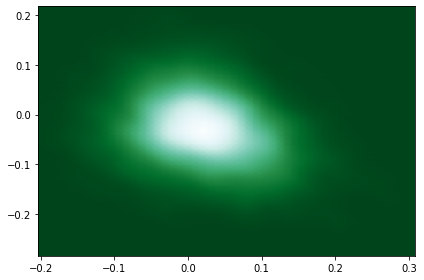

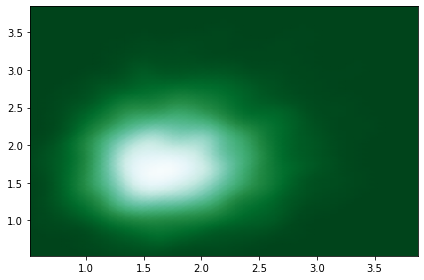

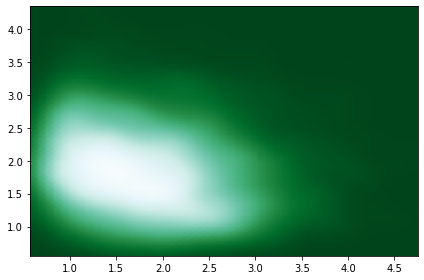

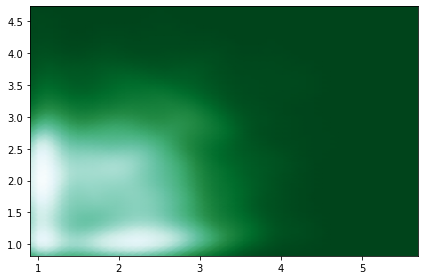

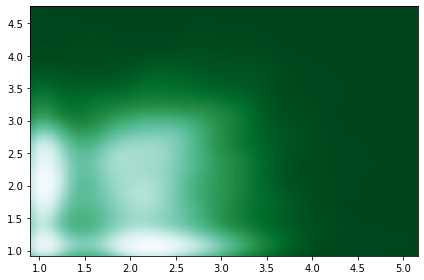

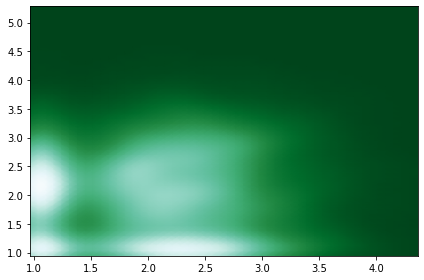

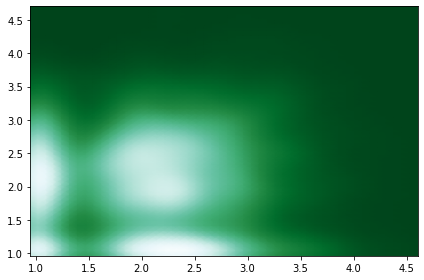

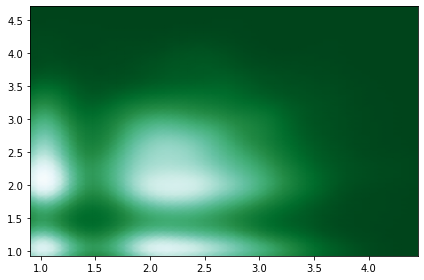

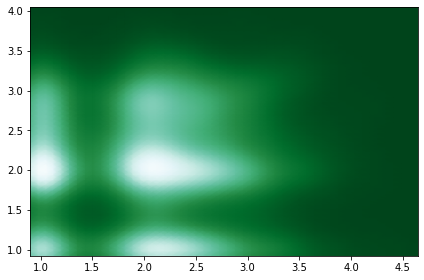

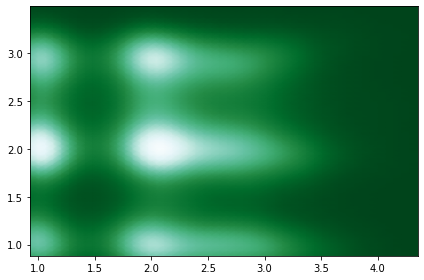

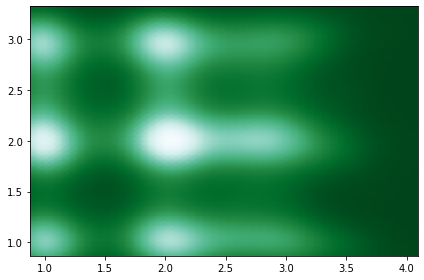

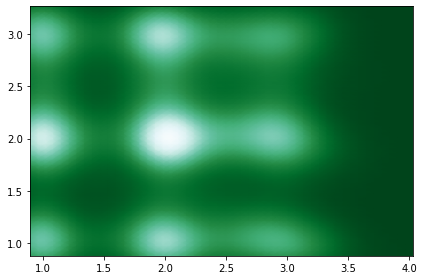

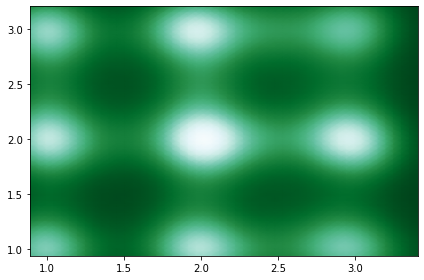

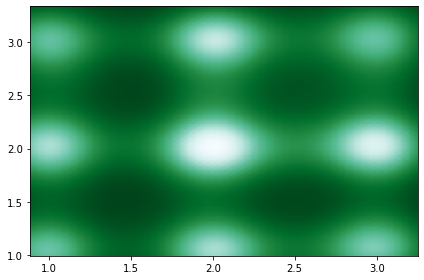

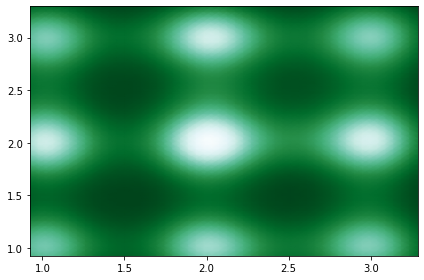

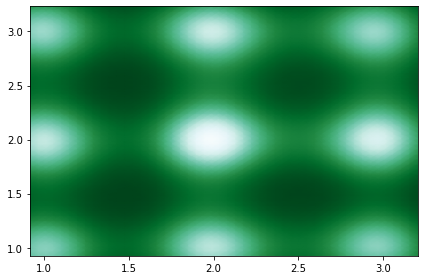

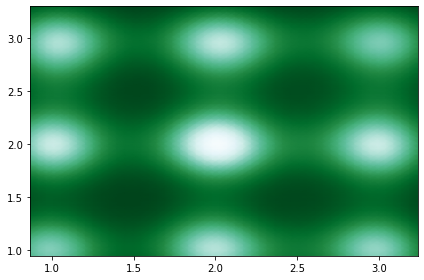

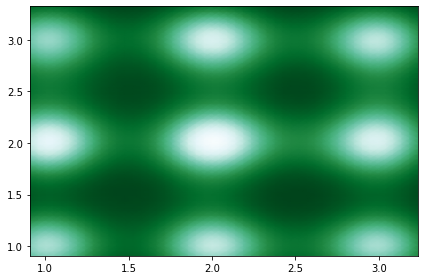

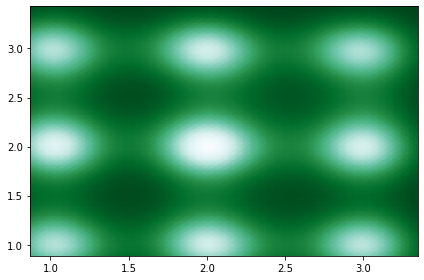

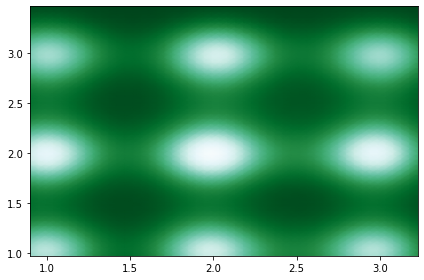

<Figure size 432x288 with 0 Axes>

In [8]:
beta = 0.01
for i in range(20000):
    s = sample(128).cuda()
    mu, logvar, out = vae(s)
    rl, kl, l = loss(s, out, mu, logvar, beta)
    opt.zero_grad()
    l.backward()
    opt.step()
    if i % 1000 == 0:
        data = vae.generate(5000)
        plot_density(data.cpu().data)

**<span style="color:blue">
    How does beta affect the performance of the VAE? Show or discuss what tradeoff beta controls, and how this can be observed from the above plots and/or any additional plots.
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

The above implementation of the VAE only worked well for values of $\beta$ surrounding 0.01. Since $\beta$ controls the "strength" of the KL-divergence term with respect to the reconstruction term in the loss function. If we consider $\beta >> 1$, the KL-divergence term will dominate the loss and the optimization procedure will converge on a model that is more consistent with our assumed prior $P(z)$. In other words, a higher value of $\beta$ puts more emphasis on the similarity of our model $P(z|x)$ to the prior $P(z)$ than on the reconstruction of $x$. On the other hand for $\beta << 1$, we emphasize the reconstruction of the image rather than our assumed prior. For our toy example, we obtain the best results in the latter case. A small value of $\beta$ yields good results within reason -- presumably because a constraint on the statistics in the latent space is necessary.

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

## GAN

Recall the GAN objective
$$\min_\psi \max_\phi \,\ \mathbb E_{x \sim Pop}[ -\ln P_\psi(1 | x) ] + \mathbb E_{z \sim \mathcal N(0,1)} [- \ln P_\psi(0|G_\phi(z))  ] \,,$$
where $G_\phi$ is a network that maps gaussian noise $z \sim \mathcal N(0,1)$ to $G(z)$ with the same shape as $x$, and $P_\psi$ is modeled by another network (the discriminator) that maps real samples $x$ and 'fake' samples $G(z)$ to a distribution over $\{0,1\}$.

We will follow the common practice of adopting a different objective for the generator network $G$:
$$\min_\phi \,\ \mathbb E_{z \sim \mathcal N(0,1)} [- \ln P_\psi(1|G_\phi(z))  ] \,.$$

First, complete the implementation of the Generator module below. The forward method takes an integer $n$ as input and should return $n$ samples $G(z), z \sim \mathcal N(0, I)$, each with dimensionality 2. You should use the self.network module for the mapping $G$.

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.network = nn.Sequential(
            nn.Linear(latent_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def decode(self, input):
        out = self.network(input)
        return out

    def forward(self, n):
        z = torch.normal(0, 1, (n,self.latent_dim)).cuda()
        samples = self.network(z).cuda()
        return samples

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )
    
    def forward(self, input):
        out = self.network(input)
        return out

In [11]:
generator = Generator(100).cuda() #100 latent dimensions
gopt = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
discriminator = Discriminator().cuda()
dopt = torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999))
criterion = torch.nn.BCEWithLogitsLoss()

Now, you'll implement the training procedure for GANs. In each iteration of the for loop below we'll update the parameters of the generator and then update the discriminator.

Fill up the missing code below. You should rely on the objective given previously to define the loss of the generator and the discriminator (both the function, the data inputs, and the target labels).

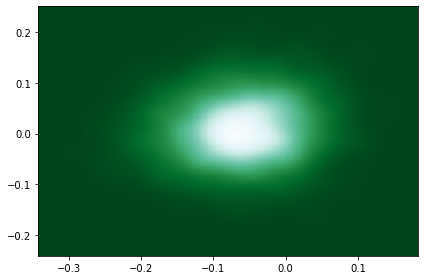

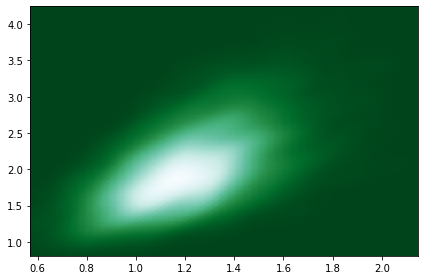

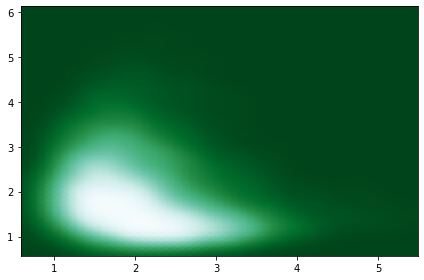

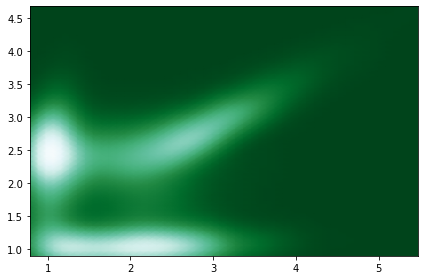

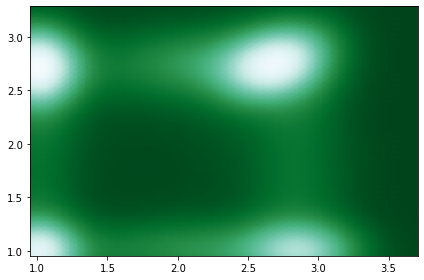

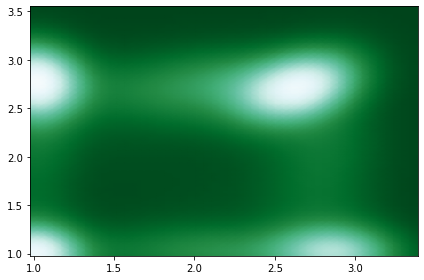

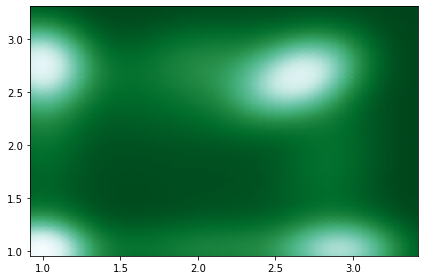

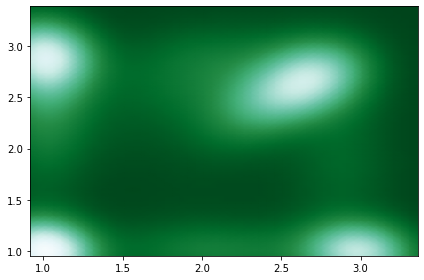

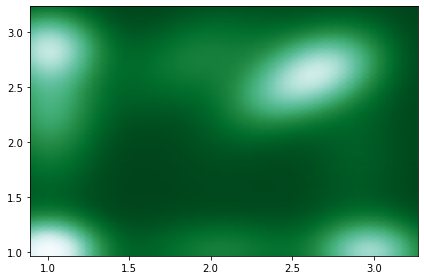

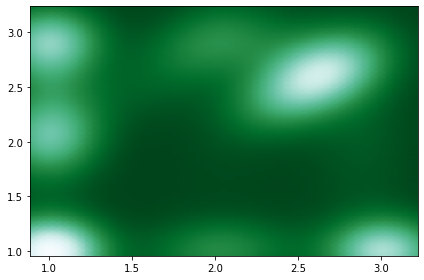

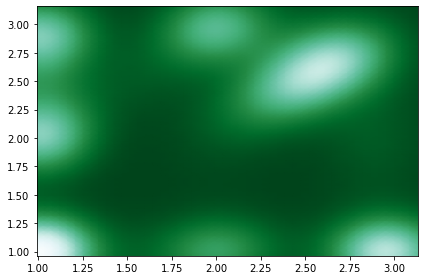

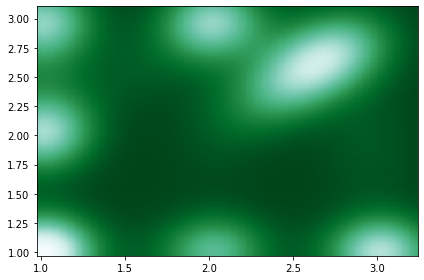

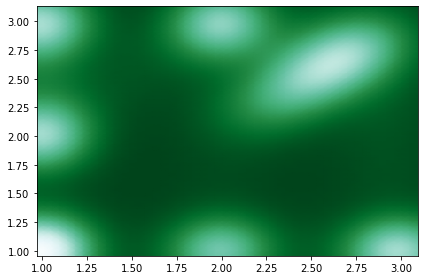

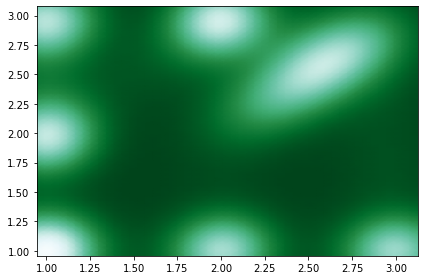

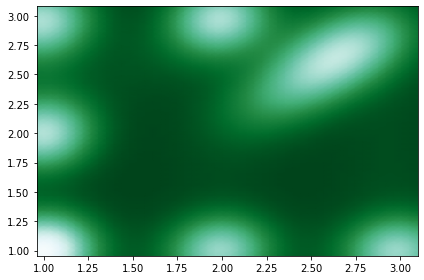

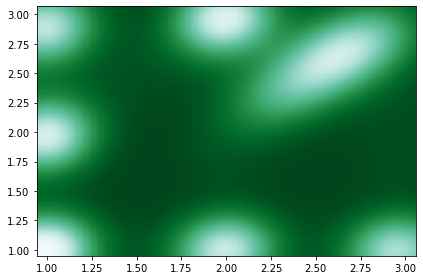

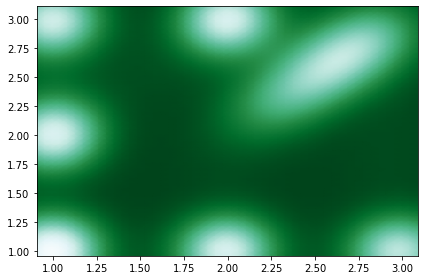

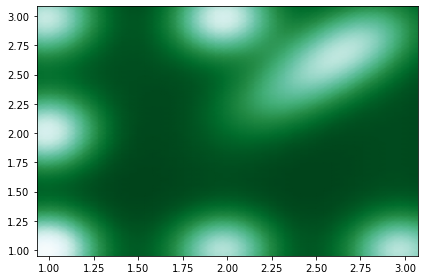

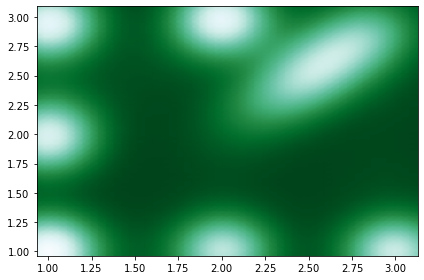

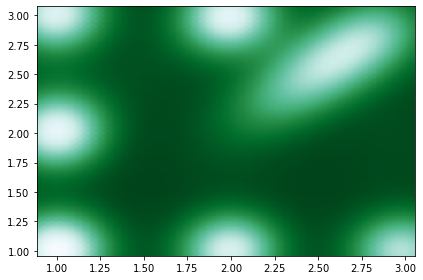

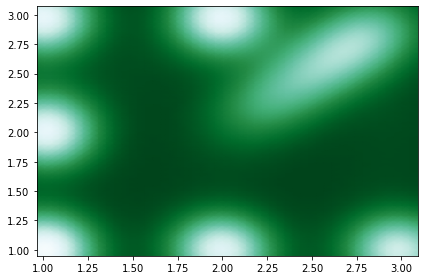

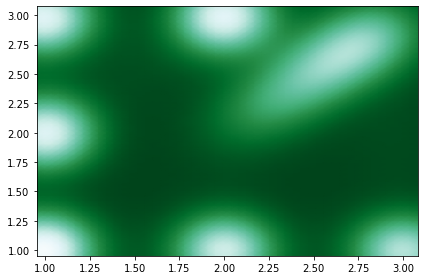

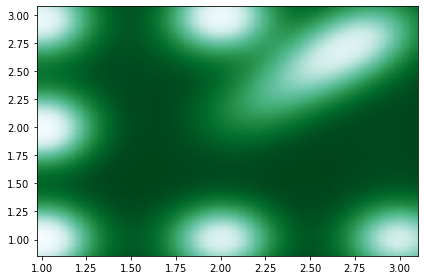

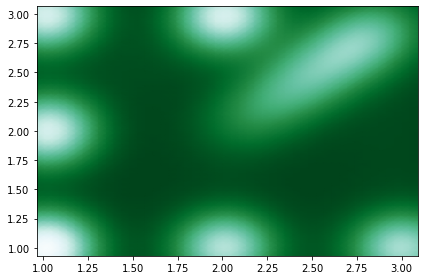

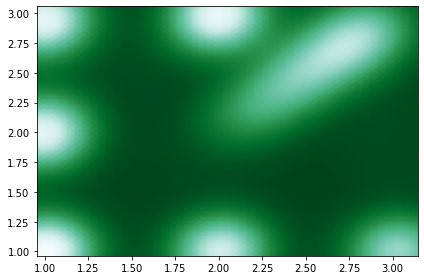

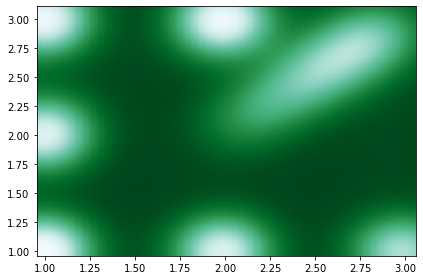

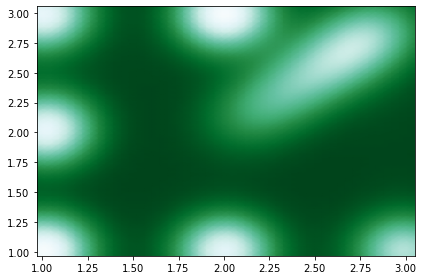

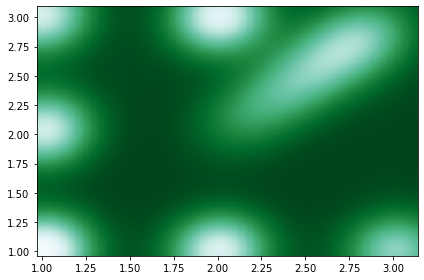

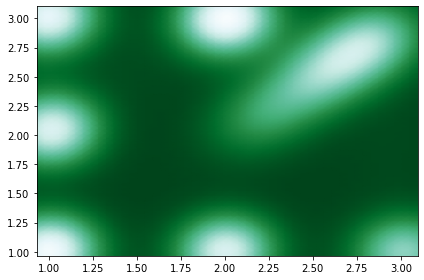

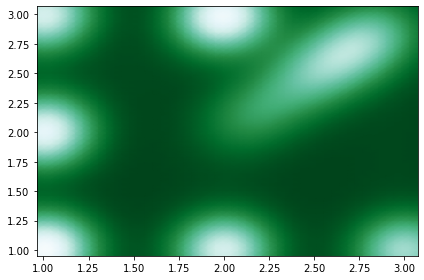

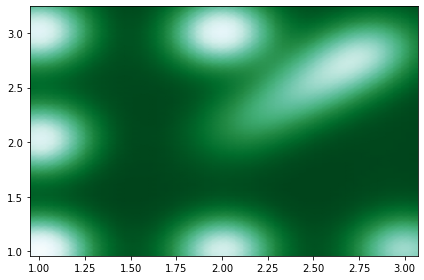

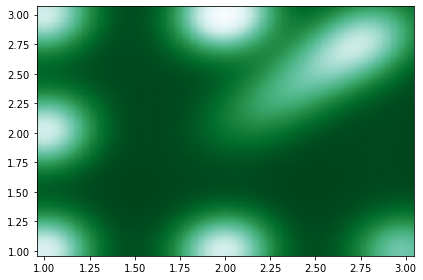

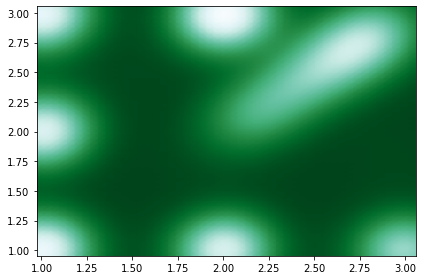

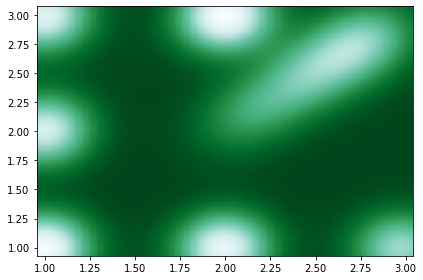

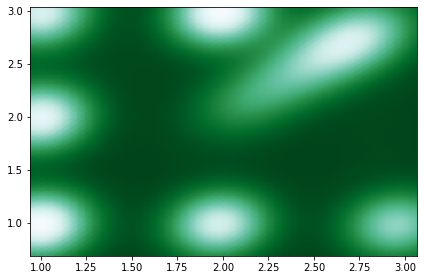

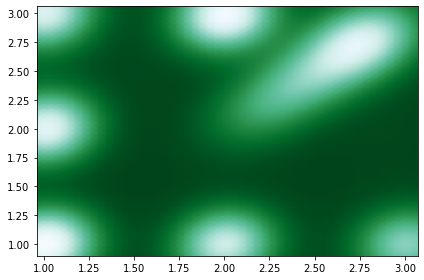

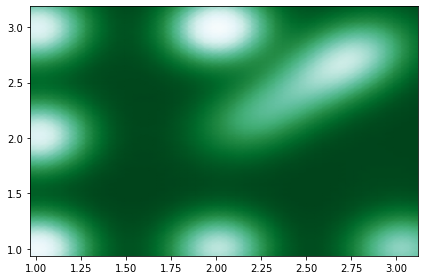

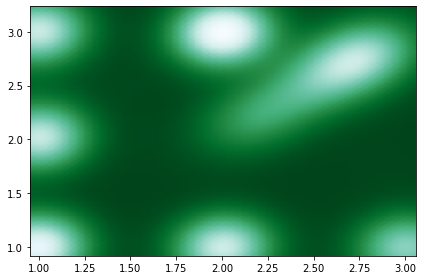

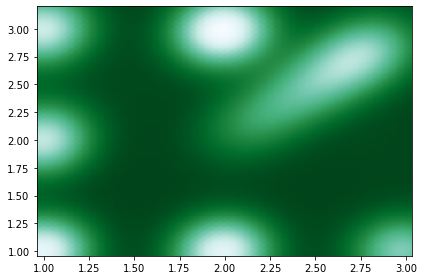

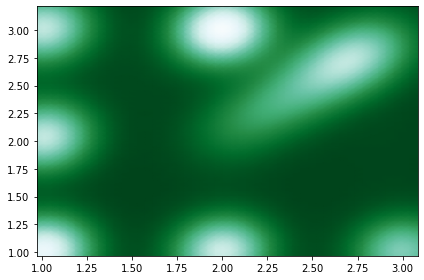

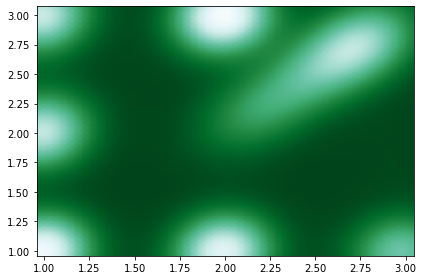

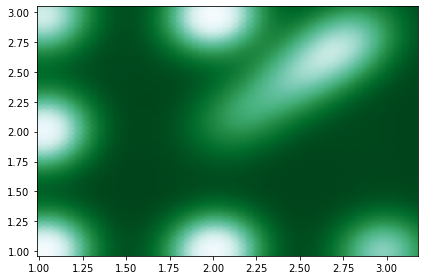

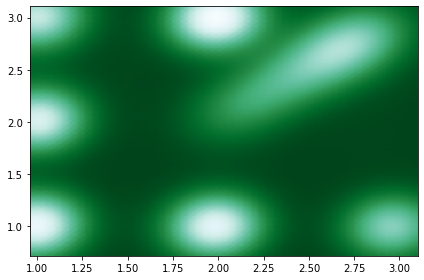

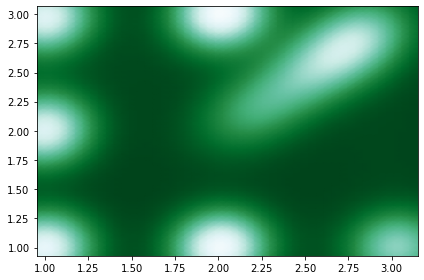

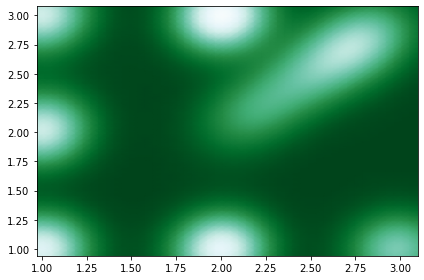

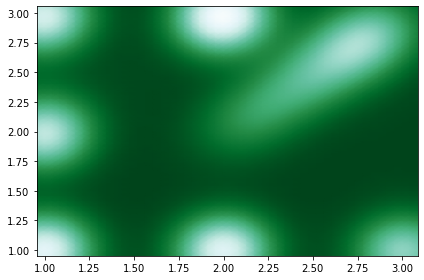

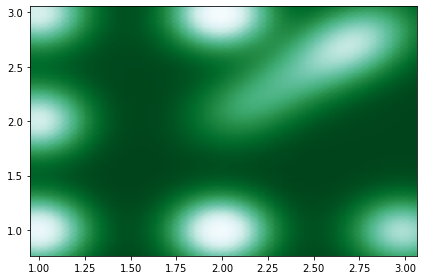

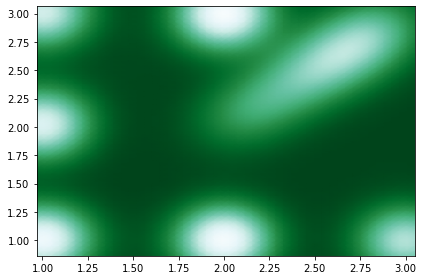

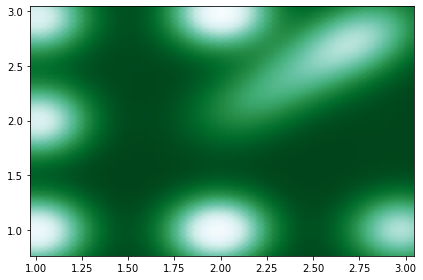

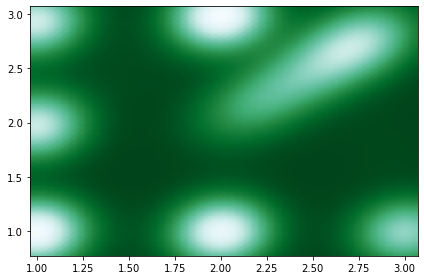

<Figure size 432x288 with 0 Axes>

In [12]:
batch_size = 128
fake_label = 0.
real_label = 1.

for i in range(50000):

    #Train the discriminator
    label = torch.full((batch_size,), real_label, dtype=torch.float).cuda()

    #Train with real batch
    discriminator.zero_grad()

    #Classify real batch, compute loss
    real_data = sample(batch_size).cuda()
    output = discriminator(real_data).view(-1)
    derror_real = criterion(output, label)
    derror_real.backward()

    #Train with fake batch
    fake = generator(batch_size)
    label.fill_(fake_label)

    # Classify fake batch, compute loss
    output = discriminator(fake.detach()).view(-1)
    derror_fake = criterion(output, label)
    derror_fake.backward()
    
    derror = derror_real + derror_fake
    dopt.step()

    #Train the generator 
    generator.zero_grad()
    label.fill_(real_label)

    #Classify fake batch
    output = discriminator(fake).view(-1)
    gerror = criterion(output, label)
    gerror.backward()

    # Update G
    gopt.step()
    
    if i % 1000 == 0:
        data = generator(5000)
        plot_density(data.cpu().data)

**<span style="color:blue">
    Compare and discuss the results you obtained with the VAE and with the GAN approach.
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

The GAN took much longer to train and at the same time never reconstructed the input to the degree the VAE did after double the number of iterations. I expect that it can be shown mathematically that the VAE should outperform the GAN on the stochastic process we have designed. Qualitatively, this is possibly due to the ability of the VAE to model the stochastic process we have designed more directly than the GAN. The VAE itself is modeling the input using a multivariate Gaussian and the toy example is just a set of 2D gaussians with means 1, 2 or 3.

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

## VAE and GANs on CelebA/MNIST

In this second part of the assignment you'll train a VAE and a GAN on a more interesting dataset. The cell below will try to download and load CelebA, and will just load MNIST in case there is an error.

It is likely that you'll get an error when trying to download CelebA since the its google drive is always out of quota. If you'd like to use CelebA anyway, you can try to download it from here http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html or some other source. If you're not running this notebook on a GPU then use MNIST instead.

In [13]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(64), transforms.CenterCrop(64), transforms.Normalize((0.5,), (0.5,))])
try:
    dataset = datasets.CelebA("data", split='all', download=True, transform=transform)
except:
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

We'll use a a CNN for the VAE instead of the simple model we defined previously.
Implement a network following these specifications:

- Encoder. Should have 4 conv layers, each with kernel size 4, stride 2 and padding 1, which decrease the spatial resolution by half. The output of the 4th conv (a spatial res. 4x4) should be flattened and then fully connected layers should be used to compute mu and logvar. Add whichever activation function you prefer between the conv layers (ReLU, LeakyReLU, ELU, etc), and feel free to add batch norm as well. Let the first conv layer have, say, 8 or 16 channels and then double the number of channels at each following conv layer.

- Decoder. Try to have an architecture that is roughly symmetric to the encoder. For example, start with a fully connected layer to project the latent_dim dimensional input such that you end up wuth a (128*4*4)-dimensional vector that you can reshape into a 4x4 image. Then you can apply 4 transposed conv layers, e.g. with kernel size 4, stride 2 and padding 1, to double the spatial resolution with each layer, having a final output of size 64x64. Start with around 64 or 128 channels for the first transposed conv and then halve the number of channels at each following conv layer. As before, add your preferred activation function between layers, with or without batch norm.

The encode, sample, and decode methods have the same specification as before.

In [14]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim, hidden_dim=1024):
        super(ConvVAE, self).__init__()

        self.latent_dim = latent_dim
        nc=1; ndf=8; ngf=8

        self.encoder = nn.Sequential(
            
            #Layer 1
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            #Layer 2
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            #Layer 3
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            #Layer 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder = nn.Sequential(

            #Layer 1
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            #Layer 2
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            #Layer 3
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            #Layer 4
            nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(True),
        )

        self.mu = nn.Linear(1024, latent_dim)
        self.logvar = nn.Linear(1024, latent_dim)
        self.hidden = nn.Linear(latent_dim, 1024)

    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + (eps * std)
        return z

    def encode(self, input):
        conv = self.encoder(input)
        conv = conv.view(-1, 1024)
        mu, logvar = self.mu(conv), self.logvar(conv)
        return mu, logvar
      
    def decode(self, z):
        x = self.hidden(z)
        x = x.view(-1,64,4,4)
        out = self.decoder(x)
        return out
            
    def forward(self, input):

        mu, logvar = self.encode(input)
        z = self.sample(mu, logvar)
        decoded = self.decode(z)

        return mu, logvar, decoded
    
    def generate(self, n):
        z = torch.randn(n, self.latent_dim).cuda()
        samples = self.decode(z)
        return samples

In [15]:
vae = ConvVAE(100).cuda()
opt = torch.optim.Adam(vae.parameters(), lr=5e-4)

The cell below applies a 'patch' in case you're using google colab (cv2_imshow doesn't work properly on google colab without it). Feel free to comment out the first import if you're not using google colab (you might have to add from cv2 import cv2_imshow, though).

In [16]:
from google.colab.patches import cv2_imshow
import cv2

def show(x):
    img = x.data.cpu().permute(1, 2, 0).numpy() * 255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2_imshow(img)

Again, try to find a value for beta that yields reasonable results.

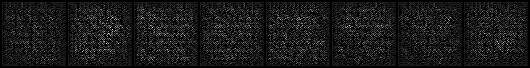

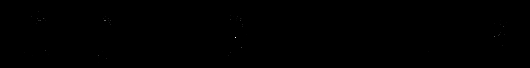

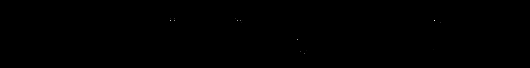

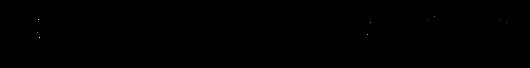

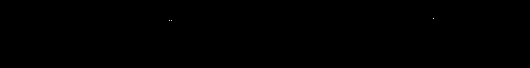

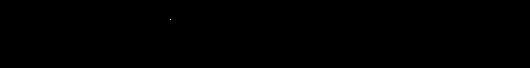

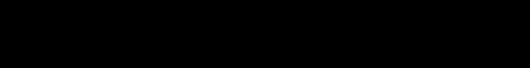

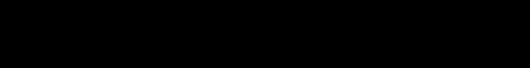

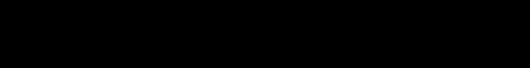

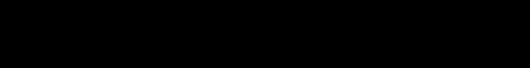

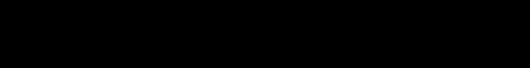

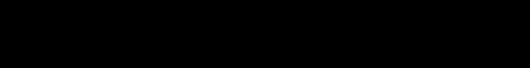

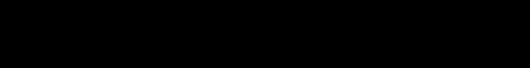

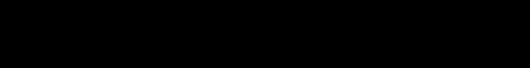

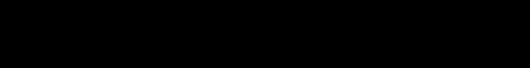

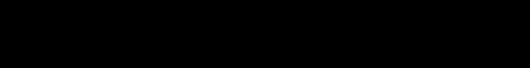

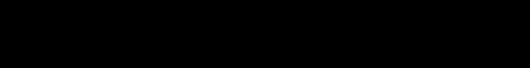

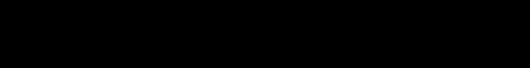

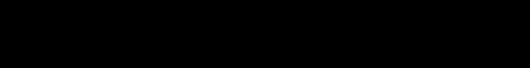

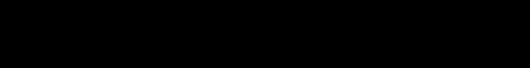

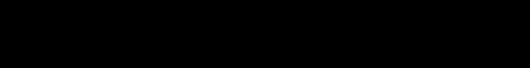

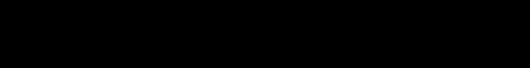

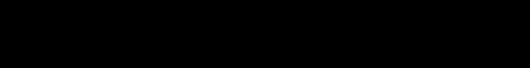

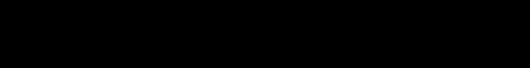

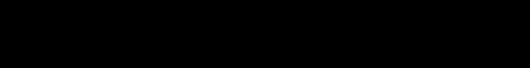

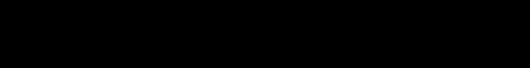

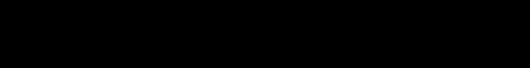

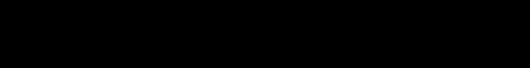

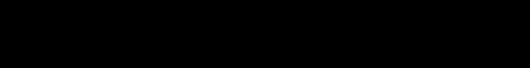

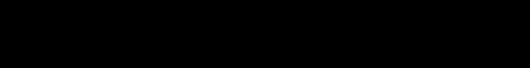

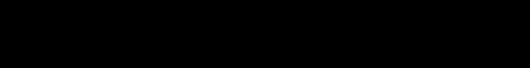

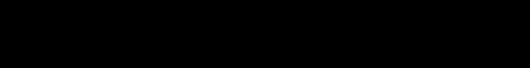

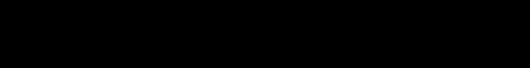

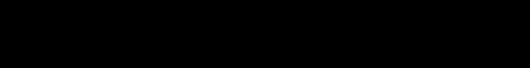

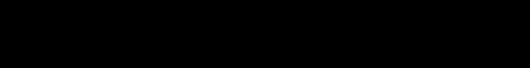

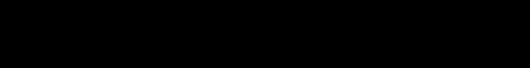

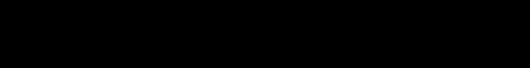

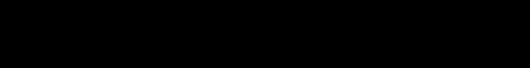

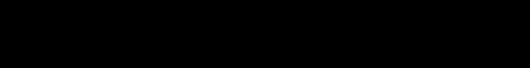

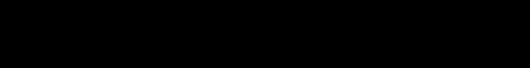

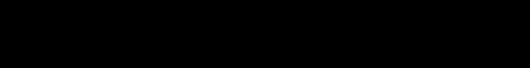

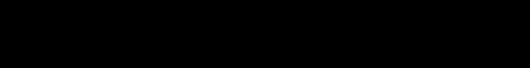

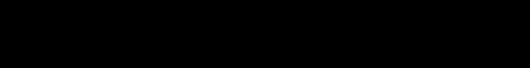

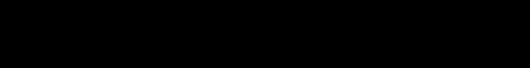

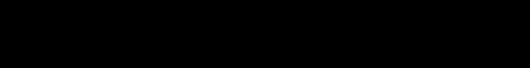

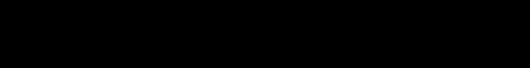

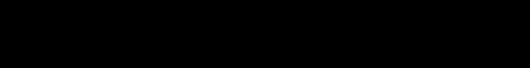

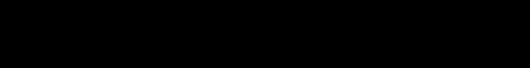

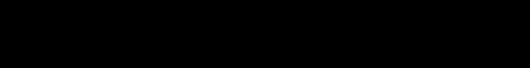

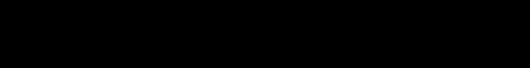

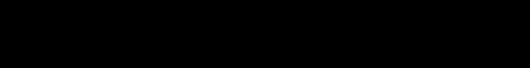

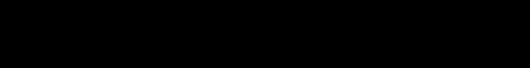

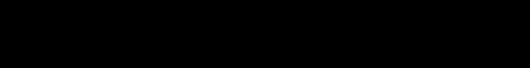

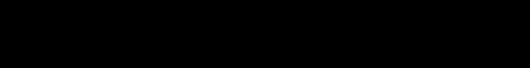

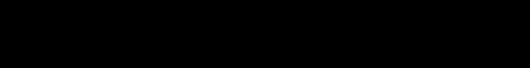

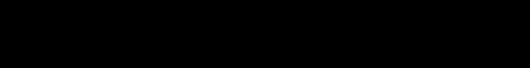

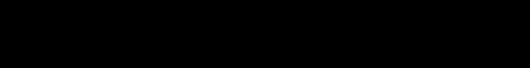

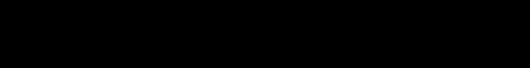

KeyboardInterrupt: ignored

In [17]:
beta = 2
for epoch in range(100):
    for i, x in enumerate(loader):
        if len(x) == 2:
            x = x[0]
        x = x.cuda()
        
        mu, logvar, out = vae(x)
        rl, kl, l = loss(x, out, mu, logvar, beta)

        opt.zero_grad()
        l.backward()
        opt.step()

        if i == 0:
            vae.eval()
            data = vae.generate(8)
            grid_img = torchvision.utils.make_grid(data, nrow=8, normalize=True)
            show(grid_img)
            vae.train()

You'll also re-implement the Generator and Discriminator modules for the GAN, adopting a CNN-like architecture.

For the generator, implement a network similar to the one you used for the VAE decoder (fully connected for projection followed by 4 transposed convolutions), while for the discriminator you should use a network similar to the VAE encoder (4 conv layers with stride 2, but note that the output should be a scalar per image, not a latent vector).

In [3]:
#####Configuration cell#######

lr = 0.0002
num_epochs = 5 #number of epochs to train
batch_size = 32
nz = 100 #noise dimension
nc = 1 #number of channels in the training images
ngf = 64 #size of feature maps in generator
ndf = 64 #size of feature maps in discriminator
real_label = 1.
fake_label = 0.

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #Prep input
            nn.ConvTranspose2d(nz, 8*ngf, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            #Layer 1
            nn.ConvTranspose2d(8*ngf, 4*ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            #Layer 2
            nn.ConvTranspose2d(4*ngf, 2*ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            #Layer 3
            nn.ConvTranspose2d(2*ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            #Layer 4
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise):
        #noise = torch.randn(batch_size, nz, 1, 1).cuda()
        return self.main(noise)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #Prep input
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            #Layer 1
            nn.Conv2d(ndf, 2*ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            #Layer 2
            nn.Conv2d(2*ndf, 4*ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            #Layer 3
            nn.Conv2d(4*ndf, 8*ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8*ndf),
            nn.LeakyReLU(0.2, inplace=True),
            #Layer 4
            nn.Conv2d(8*ndf, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(64), transforms.CenterCrop(64), transforms.Normalize((0.5,), (0.5,))])
try:
    dataset = datasets.CelebA("data", split='all', download=True, transform=transform)
except:
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
generator = Generator().cuda()
gopt = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
discriminator = Discriminator().cuda()
dopt = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = torch.nn.BCELoss()

#Initialize network weights
discriminator.apply(weights_init)
generator.apply(weights_init)

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(loader):

        #Train the discriminator
        label = torch.full((batch_size,), real_label, dtype=torch.float).cuda()

        #Train with real batch
        discriminator.zero_grad()

        #Classify real batch, compute loss
        output = discriminator(data[0].cuda()).view(-1)
        derror_real = criterion(output, label)
        derror_real.backward()

        #Train with all-fake batch
        noise = torch.randn(batch_size, nz, 1, 1).cuda()
        fake = generator(noise)
        label.fill_(fake_label)

        # Classify fake batch, compute loss
        output = discriminator(fake.detach()).view(-1)
        derror_fake = criterion(output, label)
        derror_fake.backward()

        derror = derror_real + derror_fake
        dopt.step()

        #Train the generator 
        generator.zero_grad()
        label.fill_(real_label)

        #Classify fake batch
        output = discriminator(fake).view(-1)
        gerror = criterion(output, label)

        # Calculate gradients for G
        gerror.backward()

        # Update G
        gopt.step()
                
        if i == 0:
            grid_img = torchvision.utils.make_grid(fake[:8], nrow=8, normalize=True)
            show(grid_img)


**<span style="color:blue">
    Compare and discuss the results you obtained with the VAE and with the GAN approach for this new dataset. Which of the two approaches was able to generate more realistic samples? Which of the two did you feel that you understood better (there is no correct answer here), and why? Mention one advantage and disadvantage of each of the two methods -- these should be precise properties about each approach, with a focus on what each method can and cannot do. Feel free to check papers, the original GAN paper might be especially helpful.
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

My implementation of the Convolutional VAE was not entirely functional in the end (I believe that the architecture is very close but there is a small bug or perhaps more layers in the decoder are required). However, my implementation of the DCGAN did work quite well after reading through the original paper and using some of the suggested constraints on the intialization of network parameters. 

If the Convolutional VAE had worked, I would expect it to perform slightly worse than the GAN and that $\beta > 1$ would would have been optimal. Because of the variability inherent to handwritten digits, constraints on the latent distribution are arguably more important than an exact reconstruction. It would have performed worse than the GAN because the GAN places less constraints and has more "freedom" to learn an approximate population distribution of handwritten digits. 

An advantage of the GAN is that it doesn't require knowledge of a prior over the latent space while this is a disadvantage for the VAE because it requires that you specify such a prior. However, perhaps the performance of the GAN is sensitive to the ininitialization of the network parameters (I did not test this for a variety of initializations). 

In addition, the distribution over latent space of the VAE could provide useful information on the properties of the inputs which may be useful in certain applications (protein sequencing comes to mind) while the GAN does not provide that information as directly as the VAE.

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**